In [2]:
#regrssion ; continous 출력 값을 예측!!

In [1]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pathlib
%matplotlib inline

import matplotlib as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-rc1


In [3]:
#Auto MPG dataset
#데이터 구하기
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'C:\\Users\\82104\\.keras\\datasets\\auto-mpg.data'

In [32]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [33]:
#데이터 정제하기
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [34]:
dataset = dataset.dropna() #문제간단하게 하기 위해 누락된 행 삭제

In [35]:
#Origin열은 수치형이 아니라 범주형이므로 one-hot encoding으로 변환
origin = dataset.pop('Origin')
#pop은 리스트에서 요소 끄집어내는거 즉, dataset은 현재 'Origin'이 빠진 상태

In [36]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [37]:
#데이터셋을 훈련세트와 테스트셋으로 분할
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
#80% 샘플 반환하겠다.
#random_state = seed value
test_dataset = dataset.drop(train_dataset.index)

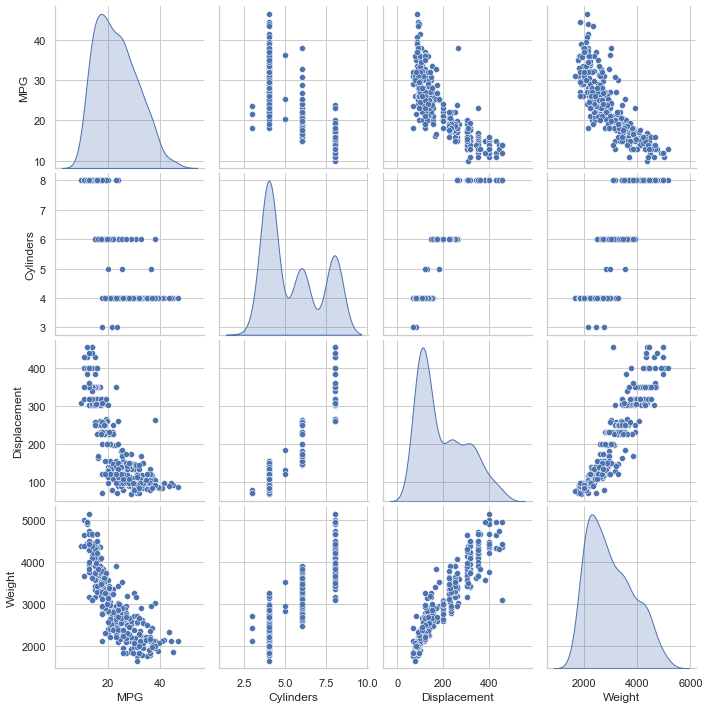

In [38]:
#데이터 조사하기
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [40]:
train_stats = train_dataset.describe()
#다양한 통계량을 요약
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [41]:
#특성과 레이블 분리하기
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [43]:
#데이터 정규화
#특성의 스케일, 범위 다르면 normalization 권장
#의도적으로 훈련 세트만 사용하여 통계치 생성
#이 통계는 테스트 세트 정규화할 때도 사용된다.
#이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서.

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
#정규화에 사용된 통계치(평균, 표준편차)는 모든 데이터에 적용되어야한다.(원핫인코딩과 마찬가지)
#테스트세트는 물론 실전에 투입되어 얻은 라이브 데이터까지

In [44]:
#모델 만들기
def build_model():
    model = keras.Sequential([
        layers.Dense(64,activation = 'relu', input_shape = [len(train_dataset.keys())]),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    
    return model

In [47]:
model = build_model()

In [48]:
#Confirmming model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [50]:
#모델 실행
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.12480301],
       [-0.0794083 ],
       [-0.23068452],
       [-0.08370322],
       [ 0.09949433],
       [-0.25000593],
       [ 0.05839977],
       [ 0.3366402 ],
       [-0.1190239 ],
       [ 0.08348204]], dtype=float32)

In [52]:
#모델 훈련 : 1000번 epoch동아 훈련

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.',end = '')
EPOCHS = 1000

history = model.fit(
normed_train_data, train_labels,
epochs = EPOCHS, validation_split = 0.2, verbose = 0,
callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [53]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.680180,1.054532,2.680180,9.294721,2.400557,9.294722,995
996,2.363465,0.932971,2.363466,9.697674,2.418902,9.697675,996
997,2.620692,0.999091,2.620692,9.250204,2.385200,9.250204,997
998,2.495963,0.977562,2.495962,9.350142,2.368192,9.350142,998
999,2.514307,1.035455,2.514307,9.153363,2.378296,9.153363,999


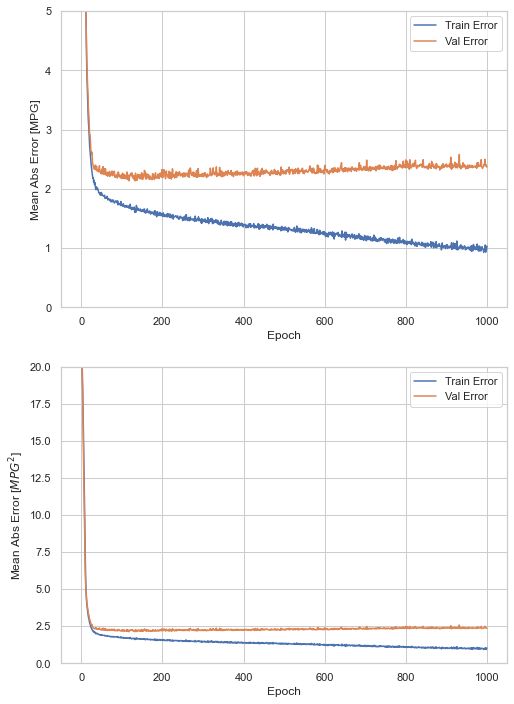

In [55]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize = (8, 12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mae'],
            label = 'Train Error')

    plt.plot(hist['epoch'],hist['val_mae'],
            label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$MPG^2$]')
    plt.plot(hist['epoch'],hist['mae'],
            label = 'Train Error')

    plt.plot(hist['epoch'],hist['val_mae'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()
    
plot_history(history)

In [56]:
#수백번의 에포크 후 모델이 거의 향상되지 않음
#model.fit수정해서 validation 점수가 향상되지 않으면 자동으로 훈련 멈추도록 설정
#에포크마다 훈련 상태를 점검하기 위해 EarlyStopping callback 사용한다.


......................................................

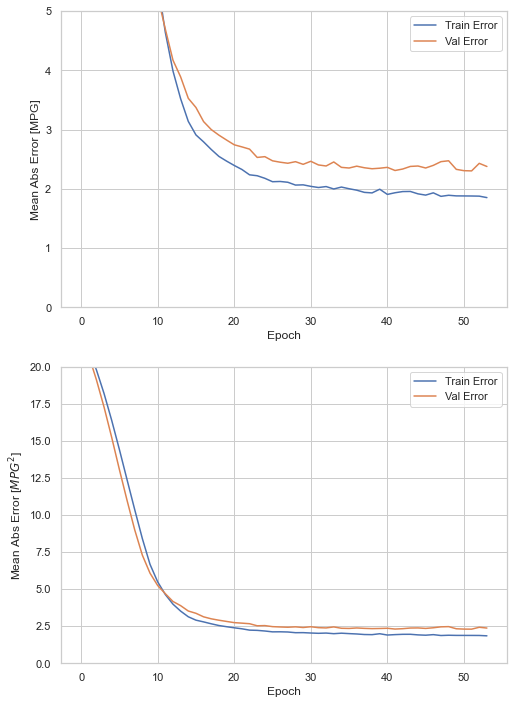

In [59]:
model = build_model()
# patience 매개변수는 성능 향상을 체크할 에포크 횟수.
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS,
                   validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])

plot_history(history)

In [62]:
#테스트 세트에서 모델 성능 확인

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:0.3f} MPG".format(mae))

78/78 - 0s - loss: 6.2438 - mae: 1.9206 - mse: 6.2438
테스트 세트의 평균 절대 오차: 1.921 MPG


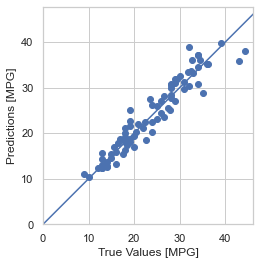

In [72]:
#예측 : 테스트 세트에 있는 샘플 사용해 MPG 값 예측

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_=plt.plot([-100,100],[-100,100])

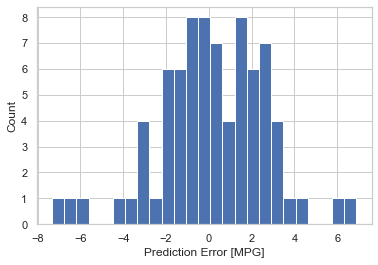

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_= plt.ylabel("Count")

In [ ]:
#MSE : 회귀문제에서 자주 사용하는 Loss
#MAE(평균 절댓값 오차) : 회귀에서 자주 사용하는 평가지표
#수치 입력 데이터의 특성이 여러가지 범위를 가질 때, 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야한다.
#훈련 데이터가 많지 않다면 overfitting막기 위해 hidden layer 개수가 적은 소규모 네트워크 선택이 좋다.
#Early stopping은 overfitting방지위한 좋은 방법